<a href="https://colab.research.google.com/github/minhtien1405/compress_algo_with_MDL/blob/main/Tien's_Thesis_MDL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Student name: **Hoang Le Minh Tien**

Project: **Minimum Description Length Induction of statistical structure in text: text compression and comparison**

Supervisor: **Dr.Peter Foldiak**

Budapest, 2021

In [ ]:
!pip install bitarray
!pip install pdfplumber

     |████████████████████████████████| 71kB 3.4MB/s 
  Created wheel for bitarray: filename=bitarray-2.1.0-cp37-cp37m-linux_x86_64.whl size=147704 sha256=6951a582ea14fbeb7c431759bc427a535f21d1a12a6b32bf386fcf0da35c5fb5
  Stored in directory: /root/.cache/pip/wheels/35/50/3a/d5c4da0c9ab92707530efe6da2f908c89946c16c1da918b503
Successfully built bitarray
     |████████████████████████████████| 51kB 2.7MB/s 
     |████████████████████████████████| 5.6MB 7.4MB/s 
     |████████████████████████████████| 143kB 41.3MB/s 
     |████████████████████████████████| 1.9MB 43.9MB/s 
  Created wheel for pdfplumber: filename=pdfplumber-0.5.28-cp37-none-any.whl size=32222 sha256=21cd50b5b726acd3648349a7497ce58c266fc60353bb8e4908c5ce46085d5ecd
  Stored in directory: /root/.cache/pip/wheels/5a/9b/3d/37e37d93650be964fdd2a9babf174214fec8a0f4d222d474ab
Successfully built pdfplumber


In [ ]:
from collections import Counter
import math
import numpy as np
from tqdm import tqdm
import copy
import sys
from scipy import sparse
from bitarray import bitarray
import pickle
import time
from matplotlib import pyplot as plt
from graphviz import Digraph
import pdfplumber
import re

In [ ]:
import nltk
nltk.download('gutenberg')

[nltk_data] Downloading package gutenberg to /root/nltk_data...
[nltk_data]   Unzipping corpora/gutenberg.zip.


True

In [ ]:
def clean_text(text):
    """
        text: a string
        return: modified initial string
    """
    text = re.sub(r'(\n\s*)+\n+', '\n\n', text)
    return text

In [ ]:
text = nltk.corpus.gutenberg.raw('austen-emma.txt')

In [ ]:
text_length = len(text)
text_length

887071

In [ ]:
voc_count = Counter(text)
voc_dl = dict()   # - log p of each character
for key in voc_count:
    voc_dl[key] = -math.log(voc_count[key]/text_length,2)

In [ ]:
# A Huffman Tree Node
class HuffmanNode:
    def __init__(self, freq, symbol, left=None, right=None):
        # frequency of symbol
        self.freq = freq
 
        # symbol name (charecter)
        self.symbol = symbol
 
        # node left of current node
        self.left = left
 
        # node right of current node
        self.right = right
 
        # tree direction (0/1)
        self.huff = bitarray()

def convert_tree_to_dict(node, bitarray_dictionary, val=bitarray()):
    # huffman code for current node
    newVal = val + node.huff

    # if node is not an edge node
    # then traverse inside it
    if(node.left):
        convert_tree_to_dict(node.left,  bitarray_dictionary, newVal)
    if(node.right):
        convert_tree_to_dict(node.right, bitarray_dictionary,  newVal)

        # if node is edge node then
        # display its huffman code
    if(not node.left and not node.right):
        bitarray_dictionary[node.symbol]= newVal
    return bitarray_dictionary

def huffman_code_of_dict(vocab, length):
    trie_freq_dict = {k:(v.count_all_text/length) for k,v in vocab.vocab_dict_address.items() if (v.is_end == True)}
    
    for key, value in trie_freq_dict.items():
        if value ==0:
            trie_freq_dict[key] = 10**-7

    print(f'Dictionary len {len(trie_freq_dict)}')
    # print(trie_freq_dict)

    nodes = []
    for key, freq in trie_freq_dict.items():
        nodes.append(HuffmanNode(freq/length, key))

    #Initialization sort
    nodes = sorted(nodes, key=lambda x: x.freq)
    while (len(nodes) > 1):
        left = nodes[0]
        right = nodes[1] 
        
        # assign directional value to these nodes
        left.huff = bitarray('0')
        right.huff = bitarray('1')
    
        # combine the 2 smallest nodes to create
        # new node as their parent
        # print(left.symbol+right.symbol)
        new_freq = left.freq+right.freq
        newNode = HuffmanNode(left.freq+right.freq, left.symbol+right.symbol, left, right)
    
        # remove the 2 nodes and add their
        # parent as new node among others

        nodes.remove(left)
        nodes.remove(right)

        #Adding new updated node to the right position
        #Adding new updated node to the right position
        if len(nodes) >1:
          for i in range(1,len(nodes)):
            if (nodes[0].freq > new_freq):
              nodes.insert(0, newNode)
              break
            elif (nodes[i-1].freq <= new_freq) and (new_freq<=nodes[i].freq):
              nodes.insert(i, newNode)
              break
            elif (i==len(nodes)-1) and new_freq>=nodes[i].freq:
              # print('Append to the end')
              nodes.append(newNode)
        else:
          # print(f'Last case {new_freq} ')
          try:
            if new_freq<=nodes[0].freq:
              nodes.insert(0, newNode)
              break
            else:
              nodes.append(newNode)
          except:
            nodes.append(newNode)
    return nodes

In [ ]:
class TrieNode:
    """A node in the trie structure"""

    def __init__(self, char, seq, left_seg = None, right_seg = None):
        # the character stored in this node
        self.char = char
        # whether this can be the end of a word
        self.is_end = False
        # a counter indicating how many times a word is inserted
        # (if this node's is_end is True)
        self.seq = seq   # number in the sequence
        # a dictionary of child nodes
        # keys are characters, values are nodes
        self.child = {}
        self.count = 0                    #segmentation count in each batch of the text, will be used to calculate the dynamic description length
        self.count_all_text = 0
        self.dl = math.inf
        self.dynamic_dl = math.inf
        self.calibrated_dl = math.inf
        self.index = 0

        # This is used to backtrack to prun the parrent node.
        self.left_seg = left_seg
        self.right_seg = right_seg
        
class Trie(object):
    """The trie object"""

    def __init__(self):
        """
        The trie has at least the root node.
        The root node does not store any character
        """
        self.root = TrieNode("", 0)
        self.current_index = 0
        self.vocab_dict ={}
        self.vocab_dict_address = {}
        self.general_count = 0 #This variable is used to calculate the probability
        self.code_length = 0
        self.code_length_debug = 0
        self.bitarray_dict = {}
    
    def bitarray_dict_setter(self, bitarray_dict):
        self.bitarray_dict = bitarray_dict
    
    def insert(self, word, dl, left_seg = None, right_seg = None):
        """Insert a word into the trie"""
        node = self.root
        # Loop through each character in the word
        # Check if there is no child containing the character, create a new child for the current node
        for i, char in enumerate(word):
            if char in node.child:
                node = node.child[char]
            else:
                
                # If a character is not found,
                # create a new node in the trie
                new_node = TrieNode(char,i)
                new_node.index = self.current_index
                node.child[char] = new_node
                node = new_node
               
        node.dl = dl
        node.dynamic_dl = dl    # Overwriten dynamic_dl when insert
        node.calibrated_dl = dl 
        # Mark the end of a word
        node.is_end = True
        self.vocab_dict[word[:i+1]] = self.current_index
        self.vocab_dict_address[word[:i+1]] = node
        self.current_index += 1
        
        node.left_seg = left_seg
        node.right_seg = right_seg

    def reset_count_all_text(self):
        """
            Count all text variable is used to calculate the final description length as well us the length in bit of the dictionary.
            This count is increased when we call mdl_segment_with_segmentation(). Then all the leaf should be set to 0 before we count it again.
        """
        for key, item in self.vocab_dict_address.items():
            self.vocab_dict_address[key].count_all_text = 0 

    def reset_count(self):
        """
            
        """
        for key, item in self.vocab_dict_address.items():
            self.vocab_dict_address[key].count = 0 


    def calibrate_segm_DL(self, node):
        """
            After finding all segmentations, DL is needed to be calibrated because the DL of longer segmentations are 
            calculated base on batch size only. This calibration function will calculate DL of all segmentations based
            on their probability appeared in all the text.

            Using segmentation_prob = node.count_all_text/self.general_count
        """
        if node.is_end:
            segmentation_prob = node.count_all_text/self.general_count
            if segmentation_prob != 0:
                node.calibrated_dl = -math.log(segmentation_prob,2)
        for c in node.child:      
            self.calibrate_segm_DL(node.child[c])    

    def pruning_trie(self, segmentation_list):
      """
          The pruning segmentations will be removed from the vocab_dict, remove unused vocab
          
          Stage 1:
            Based on the cost to add to the dictionary. If it is in the dictionary but rarely used, then it could be remove from the dictionary 
            to save some space

          Stage 2:
            Pruning the unused segmentation by checking if any segementation is not in the final segmentation
      """ 

      #Stage 1:
      segmentation_counter = Counter(segmentation_list)
      #Sorted by len of segmentation. The aim is to remove the longer segmentation first.
      segmentation_counter = dict(sorted(segmentation_counter.items(), key = lambda i: len(i[0]), reverse= True))
      vocab_dict_address_temp = self.vocab_dict_address.copy()
      for key in segmentation_counter:
        #Condition 1:
        number_of_segmentation_occured = segmentation_counter[key]
        current_DL = number_of_segmentation_occured * self.vocab_dict_address[key].calibrated_dl
        if current_DL < 53.62849515 * 8 * 1.2:
          if (self.vocab_dict_address[key].left_seg != None) and (self.vocab_dict_address[key].right_seg != None):
              # if (self.vocab_dict_address[key][self.vocab_dict_address[key].left_seg].is_end == True)
              try:
                  # print(f'Prun -> {key}:{segmentation_counter[key]}')
                  self.vocab_dict_address[key].is_end = False
                  self.vocab_dict_address[key].dynamic_dl = math.inf
                  del self.vocab_dict[key]
                  del self.vocab_dict_address[key]
              except:
                print('One of those has already pruned')

      ## Stage 2:
      used_seg = set(segmentation_list)
      unused_semg_set = set(self.vocab_dict.keys()) - used_seg
      
      pruned_count = 0
      for key in unused_semg_set:
          if key in self.vocab_dict_address:
              try:
                  if len(key) != 1:
                      self.vocab_dict_address[key].is_end = False
                      del self.vocab_dict_address[key]
                      del self.vocab_dict[key]
          
              except:
                  print(f'Can not remove {key} from the trie dictionary')
          else:
              pruned_count +=1
      print(f'Overlaping prunded = {pruned_count}')

    def trie_length_in_bit(self, node):
      """ Using depth first search to find all the probabilities to calculate the encode length for the dictionary"""
    
      if node.is_end:
          segmentation_prob = node.count_all_text/self.general_count
          if segmentation_prob != 0:
            self.code_length -= segmentation_prob * math.log(segmentation_prob,2)
            self.code_length_debug += 1

      for c in node.child:      
          self.trie_length_in_bit(node.child[c])

In [ ]:
def mdl_segment(text, vocab, DL_type = 'dynamic', check_segmentation= False):
    """
        Finding shorter description length, used to run for all text
    """
    text_length = len(text)
    min_segm = np.full(text_length+1, np.inf)
    min_segm[0] = 0.
    back_pointers = np.empty(text_length+1, dtype=np.int)
    pointers =  set()    # pointers to possible segments
    vocab.reset_count_all_text()        #Reset count_all_text variables to 0
    segmentation_list = []
    hist_text_segmentation =[]

    if check_segmentation == True:
        if len(text) <100 and text in vocab.vocab_dict.keys():
            vocab.vocab_dict_address[text].is_end = False
        else:
            print(f'Could not find "{text}" in the vocabulary')
            return min_segm, back_pointers, segmentation_list, hist_text_segmentation

    for i, char in enumerate(text):    # for each character in the text
        pointers.add(vocab.root)    # start a new pointer at this position
        for point in pointers.copy():    # for each pointer (potential segment)
            pointers.remove(point)
            if char in point.child:
                p = point.child[char]
                pointers.add(p)
                if p.is_end == True:                               
                    if DL_type == 'dynamic':
                        # Using Dynamic description length to calculate the MDL
                        potential_new_minimum = p.dynamic_dl + min_segm[i - p.seq]   
                    else:
                        #Using Calibrated DL to calculate MDL
                        potential_new_minimum = p.calibrated_dl + min_segm[i - p.seq]   
                    if min_segm[i+1] > potential_new_minimum:
                        min_segm[i+1] = potential_new_minimum
                        back_pointers[i+1] = i - p.seq    # index of previous segment

                        if check_segmentation == True: 
                            hist_text_segmentation.append(text[i-p.seq:i+1])
                            if char not in hist_text_segmentation:
                                hist_text_segmentation.append(char)   
                            # print(text[i-p.seq:i+1])
    """
    Return the segmentation by loop from the back of the text
    """

    back_pointers[0] = 0

    j = text_length
    while j>0:
        segmentation_list.append(text[back_pointers[j]:j])  # Insert to the beginning of the list
        j = back_pointers[j]
    segmentation_list.reverse()

    segmentation_count = Counter(segmentation_list)
    # {' ': 27, 'e': 19, 'o': 13, 's': 12, 'a': 10, 'n': 10, 'm': 9, 't': 9, '\n': 9, 'i': 8, 'h': 7, 'd': 6, ',': 5, 'E': 4, 'b': 4}

    if check_segmentation == False:
        for key in segmentation_count:
            vocab.vocab_dict_address[key].count_all_text = segmentation_count[key]
            vocab.vocab_dict_address[key].calibrated_dl = -math.log(vocab.vocab_dict_address[key].count_all_text/len(segmentation_list),2)   ## devide the segmentation_list instead of the text length
        
        vocab.general_count = len(segmentation_list)

    if check_segmentation == True:
        vocab.vocab_dict_address[text].is_end = True
        print(hist_text_segmentation)
        return min_segm, back_pointers, segmentation_list, hist_text_segmentation

    return min_segm, back_pointers, segmentation_list

In [ ]:
def mdl_segment_upgrade_dictionary(text, vocab, number_of_batches = 4, demo_mode = 0):
    """
        Finding shorter description length in each batches, at the end of each run, udpate the dictionary
        
        Demo mode:
            0: Normal run
            1: Showing how many pointer at each character that the algorithm is finding for
            2: Exporting demo data to draw vertical MDL graph
    """
    avg_append_dictionary_cost = 53.62849515 * 8 * 0.8
    text_length = len(text)
    min_segm = np.full(text_length+1, np.inf)
    min_segm[0] = 0.
    back_pointers = np.empty(text_length+1, dtype=np.int)
    
    current_mat_index = [0]
    current_mat_val = [0]
    bisegm_index = []
    bisegm_val = []
    pointers =  set()    # pointers to possible segments   
    demo_data = []

  
    for i, char in enumerate(text):    # for each character in the text
    ###########################################################################################################
        if demo_mode == 1:
            print(f'\033[91m[{len(pointers)}]',end='')
            print(f'\033[0m{char}',end='')
    #########################################################################################################
        pointers.add(vocab.root)    # start a new pointer at this position

        if demo_mode != 2:
            for point in pointers.copy():    # for each pointer (potential segment)
                pointers.remove(point)
                if char in point.child:
                    p = point.child[char]
                    pointers.add(p)
                    if p.is_end == True:
                        potential_new_minimum = p.dl + min_segm[i - p.seq]   # DEBUG
                        if min_segm[i+1] > potential_new_minimum:
                            min_segm[i+1] = potential_new_minimum
                            back_pointers[i+1] = i - p.seq    # index of previous segment
        else:
            # Get demo_data for demo_mode 
            for point in pointers.copy():    # for each pointer (potential segment)
                pointers.remove(point)
                if char in point.child:
                    p = point.child[char]
                    pointers.add(p)
                    if p.is_end:                                      
                        potential_new_minimum = p.dl + min_segm[i - p.seq]   # DEBUG                          
                        seq_len = 0
                        if min_segm[i+1] > potential_new_minimum:
                            min_segm[i+1] = potential_new_minimum
                            back_pointers[i+1] = i - p.seq    # index of previous segment
                            seq_len = p.seq
                        segment = (i,i-p.seq,seq_len,text[i-p.seq:i+1],p.dl,potential_new_minimum)
                        demo_data.append(segment)
    """
    Return the segmentation by loop from the back of the text
    """
    back_pointers[0] = 0
    segmentation_list = []
    j = text_length
    while j>0:
        segmentation_list.append(text[back_pointers[j]:j])  # Insert to the end of the list
        j = back_pointers[j]
    segmentation_list.reverse()

    segmentation_length = len(segmentation_list)
    segmentation_count = Counter(segmentation_list)
    vocab.general_count += segmentation_length
        
    for key in segmentation_count:
      if (vocab.vocab_dict_address[key].is_end == True):
          vocab.vocab_dict_address[key].count += segmentation_count[key]
          vocab.vocab_dict_address[key].dynamic_dl = -math.log(vocab.vocab_dict_address[key].count/vocab.general_count,2)


    if demo_mode == 0:
        """
            Looking for new segmentation to update the dictionary
        """
        #Using Sparse matrix
        #Init
        loc_current_segm = vocab.vocab_dict[segmentation_list[0]]
        current_mat_index[0] = loc_current_segm
        current_mat_val[0] +=1
        
        #Creating and adding frequency to the sparse matrix
        for i, segm in enumerate(segmentation_list):                                  
            try:
                # print(f'{segm} ->{segmentation_list[i+1]}')
                loc_current_segm = vocab.vocab_dict[segm]
                loc_next_segm = vocab.vocab_dict[segmentation_list[i+1]]
                loc_prev_seg = vocab.vocab_dict[segmentation_list[i-1]]
                
                if loc_next_segm not in current_mat_index:                               # [current, ...]
                    current_mat_index.append(loc_next_segm)                              # [1  ,   2,...] APPENED THE INDEX OF THAT SEGMENTATION
                    current_mat_val.append(0)                                            # [0.5, 0.4,...]

                if (loc_current_segm, loc_next_segm) not in bisegm_index:             ### [(current, next),...]
                    bisegm_index.append((loc_current_segm, loc_next_segm))            ### [(1,2),(3,4),()     ]
                    bisegm_val.append(0)                                              ### [ 0.2,   0.3,       ]

                current_mat_val[current_mat_index.index(loc_next_segm)] +=1
                bisegm_val[bisegm_index.index((loc_current_segm, loc_next_segm))] +=1
                # Row header will be the current segm index, col header will be the next segm index
            except:
                print('No next segmentation')


        vocab_current_segm_prob = np.array(current_mat_val, dtype = np.float16)/segmentation_length
        bisegm_prob = np.array(bisegm_val, dtype = np.float16)/segmentation_length

        inv_dict={}
        inv_dict = {v: k for k, v in vocab.vocab_dict.items()}

        ## Adding new segmentations to the trie vocab
        updating_indexes = np.where(bisegm_prob > 0)                 # Filter out the combination of segmentation which has prob > thresshold               
        for i in updating_indexes[0]:
            row, col = bisegm_index[i]
            prob_current_segm = vocab_current_segm_prob[current_mat_index.index(row)]
            prob_next_segm = vocab_current_segm_prob[current_mat_index.index(col)]
            combine_prob = bisegm_prob[bisegm_index.index((row, col))]
            
            if (prob_current_segm * prob_next_segm < combine_prob):
                new_segment = inv_dict[row] + inv_dict[col]
                new_segment_DL = -math.log(combine_prob,2)
                #4 batches, 1st batch has 100 'th' -> 400 'th in the text
                                          #100                                     # DL(t)             #DL(h)        #DL(th)
                                  # number of time it appeared               * (DL_[current] + DL_[current+1] - DL_new_segmentation)
                number_of_times_new_segm_occured = bisegm_val[bisegm_index.index((row, col))]
                reduced_cost_DL = number_of_batches * number_of_times_new_segm_occured * ((-math.log(prob_current_segm,2) -math.log(prob_next_segm,2)) - new_segment_DL)
                                      #53 * 8
                if reduced_cost_DL > avg_append_dictionary_cost:
                    # check and remove first and last space
                    if len(new_segment) > 3:
                        if new_segment[0] == ' ':
                            new_segment = new_segment[1:]
                        if new_segment[-1] == ' ':
                            new_segment = new_segment[:-1]
                    if new_segment not in vocab.vocab_dict.keys():
                        vocab.insert(new_segment, new_segment_DL, left_seg =inv_dict[row], right_seg = inv_dict[col])
                        # print(f'Add {new_segment}')
        print('Update the dictionary!')
        print(f'Len of the dictionary: {len(vocab.vocab_dict)}')
        print(f'General Number of segmentation Count = {vocab.general_count}')

    return min_segm, back_pointers, segmentation_list, demo_data

**Algorithm:**

After initialize the new trie, the *find_MDL* will do following steps:
1.   Separate the input to *n* batches and loop through each batches:
     It will call *mdl_segment_upgrade_dictionary* with thresshold/(2^i).
     At the end of each batch, we count the frequency of each segmentation (node.count) and calculating the *dynamic description length* (count up to this batch / length up to this batch). Then, we update the dictionary based on those two conditions:


*   P(current_seg)*P(next_seg) < P(combine)
*   P(combine) > thresshold



2.   At this steps, we have the trie with dynamic DL. I ran the first loop through the text to **segment** with all the word with the new trie dictionary. *mdl_segment_with_segmentation* is called here, *dynamic_DL* is used. This function will increase the *count_all_text* variable, which helps us track the frequency of segmentations in the input text.

3.   Given *count_all_text* frequencies on step 2, at this we do as following:


*   Calibrate the DL, using *count_all_text* and *full_text_length*, the DL is recalculated and saved to *node.calibrated_dl*
*   Pruning the trie node which has 0 count (**we can set some thresshold here to prune**)
*   Initialize the Huffman code dictionary (node type -- *huffman_code_of_dict(vocab, length = full_text_length)*), convert it to a dictionary (*convert_tree_to_dict*), and then store it to the trie vocab with *vocab.bitarray_dict_setter(bitarray_dict)*

4.   Loop through the input again with *Calibrated_DL*, *pruned trie*, and *bitarray_dict*, the out put will be the DL of the output, encoded output, and the length of the pruned vocab. **MDL** of the compression will be calculated here.




In [ ]:
def find_MDL(text, vocab, number_of_loop=1, number_of_batches = 10):
  """
      Main algorithm
      Step 1: Reading batches, finding shortest DL at each batch and update the dictionary at the end
      Step 2: Running again throuhg the text to count the total number of segmentation to calibrate the DL
      Step 3: Calibrating, prunning
      Step 4: Rerun with calibrated description length, encode the text with bitarray dictionary
  """

  full_text_length = len(text)
  ### Step 1:
  for j in range(number_of_loop):
    vocab.reset_count()
    vocab.general_count = 0
    for i in tqdm(range(number_of_batches)):
      sub_text = text[i * full_text_length//number_of_batches: (i+1) * full_text_length//number_of_batches]
      min_segm, back_pointers, segmentation_list, _ = mdl_segment_upgrade_dictionary(sub_text, vocab, number_of_batches = number_of_batches, demo_mode=0)
      del min_segm, back_pointers, segmentation_list
    

  ### Step 2:
  #Using dynamic DL to recompute the segmentation for all the text, check for frequencies of those segmentations in the text
  min_seg, back_pointers, segmentation_list = mdl_segment(text, vocab, DL_type = 'dynamic')
  print(f'\n\nMDL before calibrate: {min_seg[-1:][0]}')
  del min_seg, back_pointers 

  ### Step 3:
  #Based on the counted frequencies (node.count_all_text), calibrate the DL and then recompute the minimum DL
  vocab.calibrate_segm_DL(vocab.root)
  print(f'\nLength of the vocabulary before pruning: {len(vocab.vocab_dict)}')
  vocab.pruning_trie(segmentation_list)
  del segmentation_list

  ### Step 4:
  min_seg, back_pointers, segmentation_list = mdl_segment(text, vocab, DL_type = 'calibrated') 

  nodes = huffman_code_of_dict(vocab, length = len(segmentation_list))
  bitarray_dict = {}
  bitarray_dict = convert_tree_to_dict(nodes[0], bitarray_dictionary=bitarray_dict)
  vocab.bitarray_dict_setter(bitarray_dict)

  encoded_array = bitarray()
    
  for item in segmentation_list:
      encoded_array += vocab.bitarray_dict[item]

  print(f'\nLength of the vocabulary after 1 st pruning: {len(vocab.vocab_dict)}, DL of the text is : {min_seg[-1:][0]}')

  # vocab.trie_length_in_bit(vocab.root)
  trie_code_length = len(vocab.vocab_dict) * 53.62849515 * 8
  print(f'\n\nLength in bits of the vocab:{trie_code_length}')

  MDL = [min_seg[-1:][0], trie_code_length]
  print(f'\n\nMDL:{min_seg[-1:][0] + trie_code_length}')

  size_bitarray_dict = bitarray_dict.__sizeof__()
  size_encoded_array = encoded_array.__sizeof__()
  total_size =[size_bitarray_dict,size_encoded_array]

  print(f'Total size __sizeof__ { size_bitarray_dict + size_encoded_array } bytes')
  print(f'Total size getsizeof { sys.getsizeof(encoded_array) + sys.getsizeof(bitarray_dict) } bytes')

  return min_seg, back_pointers, segmentation_list, MDL, trie_code_length, len(vocab.vocab_dict), encoded_array, total_size

In [ ]:
trie = Trie()
for key in voc_dl:
    trie.insert(key, voc_dl[key])
%prun min_seg_full_text, back_pointers_full_text, segmentation_list_full_text, sum_MDL, trie_code_length, vocab_dict_len, encoded_array, total_size = find_MDL(text, trie,number_of_loop=1, number_of_batches = 10)

 10%|█         | 1/10 [00:01<00:14,  1.60s/it]

No next segmentation
Update the dictionary!
Len of the dictionary: 337
General Number of segmentation Count = 88707
No next segmentation


 20%|██        | 2/10 [00:09<00:27,  3.42s/it]

Update the dictionary!
Len of the dictionary: 1155
General Number of segmentation Count = 141008
No next segmentation


 30%|███       | 3/10 [00:26<00:53,  7.59s/it]

Update the dictionary!
Len of the dictionary: 1770
General Number of segmentation Count = 178387
No next segmentation


 40%|████      | 4/10 [00:45<01:05, 10.90s/it]

Update the dictionary!
Len of the dictionary: 2154
General Number of segmentation Count = 211827
No next segmentation


 50%|█████     | 5/10 [01:03<01:05, 13.05s/it]

Update the dictionary!
Len of the dictionary: 2409
General Number of segmentation Count = 243261
No next segmentation


 60%|██████    | 6/10 [01:21<00:58, 14.60s/it]

Update the dictionary!
Len of the dictionary: 2623
General Number of segmentation Count = 273831
No next segmentation


 70%|███████   | 7/10 [01:39<00:47, 15.71s/it]

Update the dictionary!
Len of the dictionary: 2784
General Number of segmentation Count = 304092
No next segmentation


 80%|████████  | 8/10 [01:58<00:32, 16.48s/it]

Update the dictionary!
Len of the dictionary: 2931
General Number of segmentation Count = 333903
No next segmentation


 90%|█████████ | 9/10 [02:15<00:16, 16.82s/it]

Update the dictionary!
Len of the dictionary: 3077
General Number of segmentation Count = 363346
No next segmentation


100%|██████████| 10/10 [02:33<00:00, 15.39s/it]

Update the dictionary!
Len of the dictionary: 3173
General Number of segmentation Count = 392209




MDL before calibrate: 2471836.018592757

Length of the vocabulary before pruning: 3173
Overlaping prunded = 0
Dictionary len 1203

Length of the vocabulary after 1 st pruning: 1203, DL of the text is : 2568768.39675412


Length in bits of the vocab:516120.6373236


MDL:3084889.03407772
Total size __sizeof__ 352031 bytes
Total size getsizeof 352063 bytes
 

**Historical graph**

In [ ]:
def draw_hist_graph(gra, vocab, hist_segmentation, segmentation_list):
    """ Draw the historical graph that create the vocabulary in the trie
        This function is used after calling the `mdl_segment` with test vocabulary

        Example
        ----------
            test_vocab = 'understand'
            min_seg, back_pointers, segmentation_list, hist_segmentation = mdl_segment(test_vocab, trie, 'calibrated', check_segmentation= True)

            gra = Digraph()
            draw_hist_graph(gra, trie, hist_segmentation = hist_segmentation, segmentation_list = segmentation_list)
            gra
        ----------

        Parameters
        ----------
        gra : Digraph()
            The sound the animal makes (default is None)

        vocab : the trie vocabulary
            trie = Trie()

        hist_segmentation : list
            The historical segmentation created by `mdl_segment` indicated the way the algorithm choosed segmentations
            Example: 'understand' -> ['u', 'n', 'un', 'nd', 'd', 'd', 'e', 'nder', 'r', 'under', 's', 'st', 't', 'a', 'an', 'and', 'stand']

        segmentation_list : list
            The final segmenation by the algorithm
            Example: 'understand' -> ['under','stand']
    """

    graph_hist = []
    final_segmentation = []
    for elem in hist_segmentation:
      found = False
      for parent in hist_segmentation:
        if elem in parent and elem!=parent:
          found = True
          if (parent, elem) not in graph_hist:
            gra.edge("'" + parent + "'", "'" + elem + "'")

            #Add parent DL
            label = """< '{}' <br/> <FONT POINT-SIZE="8">DL: {:.3f}</FONT>>""".format(parent, vocab.vocab_dict_address[parent].calibrated_dl)
            gra.node("'" + parent + "'", label=label)

            #Add element DL
            label = """< '{}' <br/> <FONT POINT-SIZE="8">DL: {:.3f}</FONT>>""".format(elem, vocab.vocab_dict_address[elem].calibrated_dl)
            gra.node("'" + elem + "'", label=label)

            graph_hist.append((parent,elem))
          
          if parent in segmentation_list:
            gra.node("'"+parent+"'", style='filled', fillcolor='yellow')
            
      if not found:
      # for elem in hist_segmentation:
        target_vocab = ''.join([str(elem) for elem in segmentation_list])
        
        if (target_vocab, elem) not in graph_hist:
          final_segmentation.append(elem)
          gra.edge("'" + target_vocab + "'", "'"+elem+ "'")

          label = """< '{}' <br/> <FONT POINT-SIZE="8">DL: {:.3f}</FONT>>""".format(target_vocab, vocab.vocab_dict_address[target_vocab].calibrated_dl)
          gra.node("'" + target_vocab + "'", label=label)

          label = """< '{}' <br/> <FONT POINT-SIZE="8">DL: {:.3f}</FONT>>""".format(elem, vocab.vocab_dict_address[elem].calibrated_dl)
          gra.node("'" + elem + "'", label=label)

          graph_hist.append((target_vocab,elem))

        if elem in segmentation_list:
          gra.node("'"+elem+"'", style='filled', fillcolor='yellow')

    for elem in set(segmentation_list) - set(final_segmentation):
      # print(f'left over: {elem}')
      gra.edge("'" + target_vocab + "'", "'"+elem+ "'")
      label = """< '{}' <br/> <FONT POINT-SIZE="8">DL: {:.3f}</FONT>>""".format(elem, vocab.vocab_dict_address[elem].calibrated_dl)
      gra.node("'"+elem+"'",label=label, style='filled', fillcolor='yellow')
      graph_hist.append((target_vocab,elem))

['h', 'ha', 'a', 'p', 'p', 'pp', 'app', 'i', 'in', 'n', 'e', 's', 'iness']


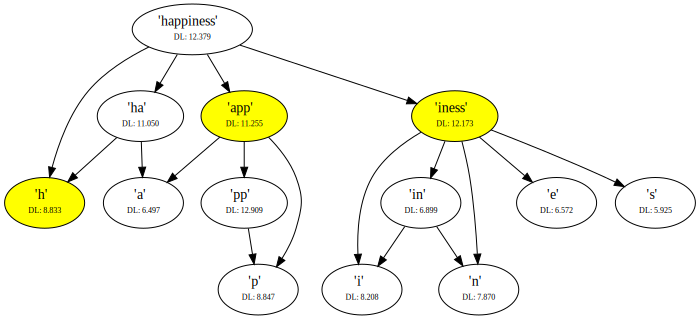

In [ ]:
## Drawing a historical graph created the vocabulary
test_vocab = 'happiness'
min_seg, back_pointers, segmentation_list, hist_segmentation = mdl_segment(test_vocab, trie, 'calibrated', check_segmentation= True)

gra = Digraph()
draw_hist_graph(gra, trie, hist_segmentation = hist_segmentation, segmentation_list = segmentation_list)
gra

**Graph from historical built word (left parent and right parent)**

In [ ]:
from graphviz import Digraph

[('Wood', 'Woodhouse')]
[('Wood', 'Woodhouse'), ('h', 'house')]
[('Wood', 'Woodhouse'), ('h', 'house'), ('ouse', 'house')]
[['Wood', ['h', 'ouse']]]


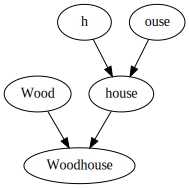

In [ ]:
gra = Digraph()

def get_sub_segmentation_and_edges(vocab_trie, segmentation, parent, memo = []):
    
    try:
        left_seg = vocab_trie.vocab_dict_address[segmentation].left_seg
    
    except:
        left_seg = None

    try:
        right_seg = vocab_trie.vocab_dict_address[segmentation].right_seg
      
    except:
        right_seg = None


    if (left_seg == None) and (right_seg == None):
        if (segmentation,parent) not in memo:
            memo.append((segmentation,parent))
            print(memo)
            gra.edge(segmentation, parent)
        return [segmentation]

    gra.edge(left_seg+right_seg,parent)
    return [get_sub_segmentation_and_edges(vocab_trie, left_seg, segmentation)+ get_sub_segmentation_and_edges(vocab_trie, right_seg, segmentation)]

print(get_sub_segmentation_and_edges(trie, 'Woodhouse', ''))
del gra.body[0]
gra


**Vertical graph**

In [ ]:
def plot_demo_data(vocab,segmentation_list,min_segm,demo_data):
    fig=plt.figure(figsize=(20,8), dpi= 100, facecolor='w', edgecolor='k')
    ax = fig.add_subplot(111)
    text_length_cursor = 0
    demo_data_cp = demo_data.copy()
    for i,segment in enumerate(segmentation_list):
        text_length_cursor += len(segment)

        # Draw main segmentation line
        x_1 = min_segm[text_length_cursor]-vocab.vocab_dict_address[segment].dl, min_segm[text_length_cursor]
        y_1 = 0,0
        plt.plot(x_1,y_1,marker='o')
        ax.annotate("'"+segment+"'", xy=(min_segm[text_length_cursor]-vocab.vocab_dict_address[segment].dl/2,0.1), textcoords='data')

        if len(segment) != 1:
            #Draw analysis
            temp_cursor = text_length_cursor
            temp_prev_cursor = text_length_cursor - len(segment)
            sub_strings = []
            for data in demo_data_cp:
                if (data[1] <=temp_cursor) & (data[1]>=temp_prev_cursor):
                  sub_strings.append(data)
            loc_i, loc_seg, hight_level, char,DL, MDL = [*zip(*sub_strings)]
            new_list = []
            for item in zip(char,DL,MDL):
              if item[0] in segment and item[0] != segment:
                new_list.append(item)
            # print(new_list)
            
            ending = {}
            count = {}
            for j in range(len(new_list)):
              A = round(new_list[j][2]-new_list[j][1],5),round(new_list[j][2],5)
              b_y =(i%4)*10+ j+1
              
              ending[round(new_list[j][2],5)] = (i%4)*10+ j+1
              count[round(new_list[j][2],5)] = 0
              if round(new_list[j][2]-new_list[j][1],5) in ending:         
                b_y = ending[round(new_list[j][2]-new_list[j][1],5)] +count[round(new_list[j][2]-new_list[j][1],5)]
                count[round(new_list[j][2]-new_list[j][1],5)] += 0.5
              B = b_y,b_y
              plt.plot(A,B,marker='o')
              ax.annotate("'"+new_list[j][0]+"'", xy=(round(new_list[j][2] - new_list[j][1]/2,5),b_y + 0.1), textcoords='data')

              if (round(new_list[j][2]-new_list[j][1],5) == round(min_segm[temp_prev_cursor],5)):
                verticle_x = round(new_list[j][2]-new_list[j][1],5),round(new_list[j][2]-new_list[j][1],5)
                verticle_y = 0, b_y
                plt.plot( verticle_x ,  verticle_y , '--',marker='o')
    plt.ylim(top=45)  
    plt.ylim(bottom=-1)
    plt.xlabel('MDL')
    plt.show()
# plot_demo_data_2(trie,segmentation_list[0:10],min_segm,demo_data)

In [ ]:
min_segm, back_pointers, segmentation_list, demo_data= mdl_segment_upgrade_dictionary(text[50:500], trie, demo_mode=2)

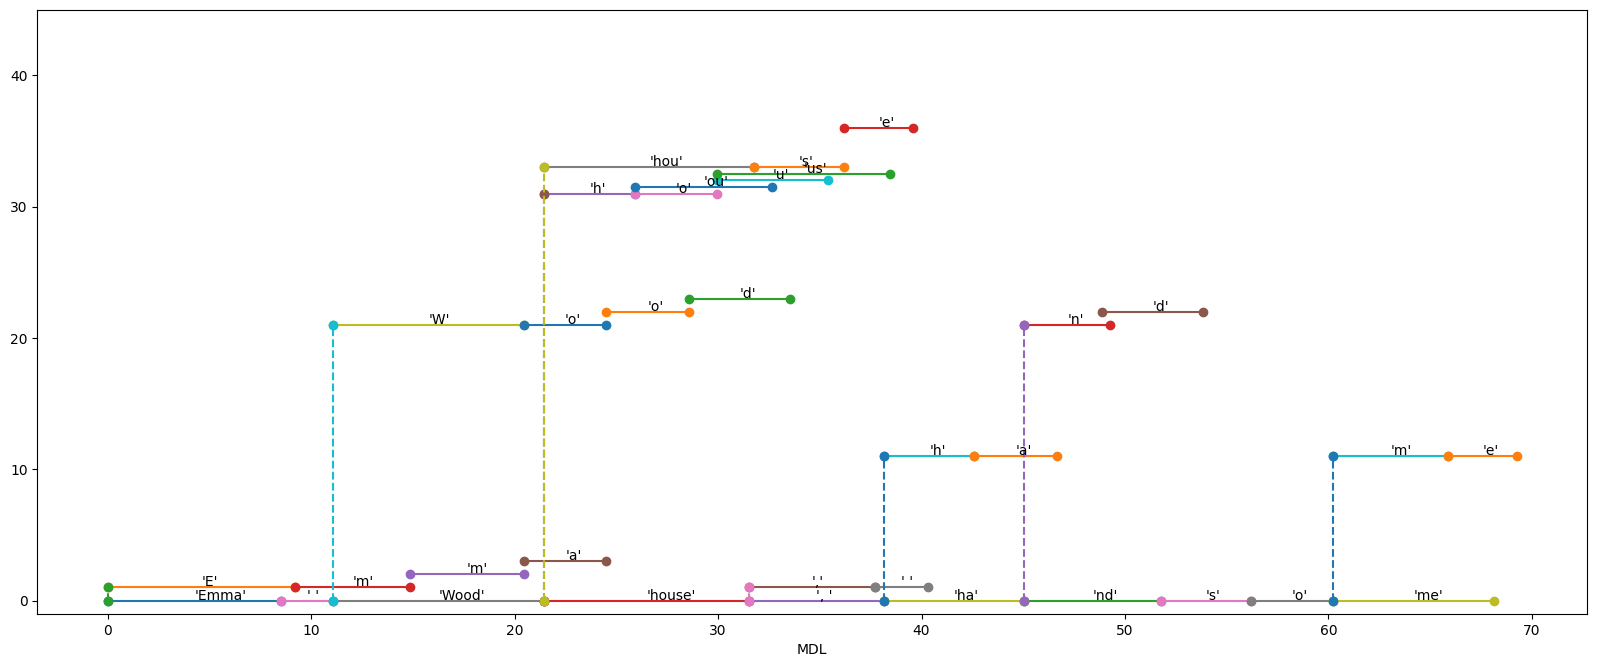

In [ ]:
plot_demo_data(trie,segmentation_list[0:10],min_segm,demo_data)

**Example of Huffman code dictionary, how it works**


1.   First I coverted the frequency dictionary to bitarray dictionary
2.   From bitarray dictionary, I converted it to a trie where each node of the trie is binary value (0,1), the values of each trie node are the dictionary key (for example, 'aa','bb'), and is_end.



In [ ]:
# freq_dict={   'a':5, 
#               'b':9,
#               'c':12,
#               'd':13,
#               'e':16,
#               'f':45,'aa':101,'bb':95}
# nodes = huffman_code_of_dict3(freq_dict, 1000)
# bitarray_dict = {}
# bitarray_dict = convert_tree_to_dict(nodes[0], bitarray_dictionary=bitarray_dict)
# bitarray_dict

**Decoder:**

    Input: bit sequence, trie decoder dictionary
    Output: text





In [ ]:
class BitArrayNote:
    """A node in the trie structure"""

    def __init__(self, vocab):
        self.vocab = vocab
        self.is_end = False 
        self.child = {}        #0/1 
        
class BitArrayTrie(object):

    def __init__(self):
        self.root = BitArrayNote("")

    def insert(self, array_of_bit, vocab):
        """Insert a word into the trie"""
        node = self.root
        # Loop through each character in the word
        # Check if there is no child containing the character, create a new child for the current node
        for i, bit in enumerate(array_of_bit):
            if int(bit) in node.child:
                node = node.child[int(bit)]
            else:  
                # If a character is not found,
                # create a new node in the trie
                new_node = BitArrayNote("")
                node.child[int(bit)] = new_node
                node = new_node
               
        # node.DL = -math.log(P(word))
        node.vocab = vocab
        node.is_end = True

In [ ]:
bitarrayTrie = BitArrayTrie()

In [ ]:
for vocab, bitcode in trie.bitarray_dict.items():
  bitarrayTrie.insert(bitcode,vocab)

In [ ]:
sys.getsizeof(trie.bitarray_dict), sys.getsizeof(encoded_array)

(36976, 349530)

In [ ]:
def decoder(bitsequence, bitarray_vocab_node):
  decoded_str = ""
  node = bitarray_vocab_node
  for i,bit in enumerate(bitsequence):
    # print(int(bit), end="")
    if int(bit) in node.child:
      node = node.child[int(bit)]
      if node.is_end:
        # print(node.vocab, end="")
        decoded_str +=node.vocab
        node = bitarray_vocab_node
  return decoded_str
# Example run:
# test_str = decoder(bit_array1, bitarrayTrie.root)
# test_str

In [ ]:
decoded_str = decoder(encoded_array, bitarrayTrie.root)

In [ ]:
len(text), len(decoded_str)

(887071, 887071)

In [ ]:
decoded_str[:100]

'[Emma by Jane Austen 1816]\n\nVOLUME I\n\nCHAPTER I\n\n\nEmma Woodhouse, handsome, clever, and rich, with a'

In [ ]:
text == decoded_str

True

Checking the size of the compression

In [ ]:
print(f'Original size {sys.getsizeof(text)} , compressed size {sys.getsizeof(encoded_array) + sys.getsizeof(trie.bitarray_dict)}')

Original size 887120 , compressed size 386506


**Create pickle file:**

In [ ]:
with open('compressed.pkl', 'wb') as f:
    pickle.dump([encoded_array, trie.bitarray_dict], f, protocol=None)
with open('compressed_dictionary.pkl', 'wb') as f_1:
    pickle.dump(trie.bitarray_dict, f_1, protocol=None)
with open('compressed_array.pkl', 'wb') as f_2:
    pickle.dump(encoded_array, f_2, protocol=None)

In [ ]:
!du -sb compressed.pkl
!du -sb compressed_dictionary.pkl
!du -sb compressed_array.pkl

376450	compressed.pkl
59446	compressed_dictionary.pkl
317006	compressed_array.pkl


In [ ]:
with open('original1.pkl', 'wb') as f2:
    pickle.dump(text, f2, protocol=None)

In [ ]:
!du -sb original1.pkl

41460	original1.pkl


In [ ]:
with open('compressed.pkl', 'rb',) as f3:
     obj0, obj1  = pickle.load(f3)

In [ ]:
bitarrayTrie2 = BitArrayTrie()
for vocab, bitcode in obj1.items():
  bitarrayTrie2.insert(bitcode,vocab)
decoded_text = decoder(obj0, bitarrayTrie2.root)
decoded_text[:500]

"[Emma by Jane Austen 1816]\n\nVOLUME I\n\nCHAPTER I\n\n\nEmma Woodhouse, handsome, clever, and rich, with a comfortable home\nand happy disposition, seemed to unite some of the best blessings\nof existence; and had lived nearly twenty-one years in the world\nwith very little to distress or vex her.\n\nShe was the youngest of the two daughters of a most affectionate,\nindulgent father; and had, in consequence of her sister's marriage,\nbeen mistress of his house from a very early period.  Her mother\nhad died t"

In [ ]:
decoded_text ==text

True

**Check size of pickle dictionary size**

In [ ]:
import pandas as pd

In [ ]:
test_dictionary = {}
number_of_text = 0
number_of_byte_in_bitarray = 0

num_of_key = []
num_of_bit_array = []
size_of_dict = []
file_size_array = []
count = 0
dict_key = []
dict_val = []

for key in trie.bitarray_dict:
  test_dictionary[key] = trie.bitarray_dict[key]
  number_of_text += len(key)
  number_of_byte_in_bitarray += 1 + len(trie.bitarray_dict[key])//8
  count +=1
  with open('test_pkl3.pkl','wb') as f:
    pickle.dump(test_dictionary,f, protocol=None)
  !du -sb test_pkl3.pkl > result.txt
  with open('result.txt', 'r') as f3:
    text = f3.read()
  file_size = text.split('\t')[0]  
  print(file_size)

  num_of_key.append(len(key))
  num_of_bit_array.append(1 + len(trie.bitarray_dict[key])//8)
  size_of_dict.append(count)
  file_size_array.append(file_size)
  dict_key.append(key)
  dict_val.append(str(test_dictionary[key]))


data = {'num_of_key':num_of_key,
        'num_of_bit_array':num_of_bit_array,
        'size_of_dict':size_of_dict,
        'file_size_array':file_size_array,
        'dict_key':dict_key,
        'dict_val':dict_val
        }
df = pd.DataFrame(data,columns=['num_of_key',  'num_of_bit_array',  'size_of_dict','file_size_array','dict_key','dict_val'])
df.to_csv('myDataFrame.csv')

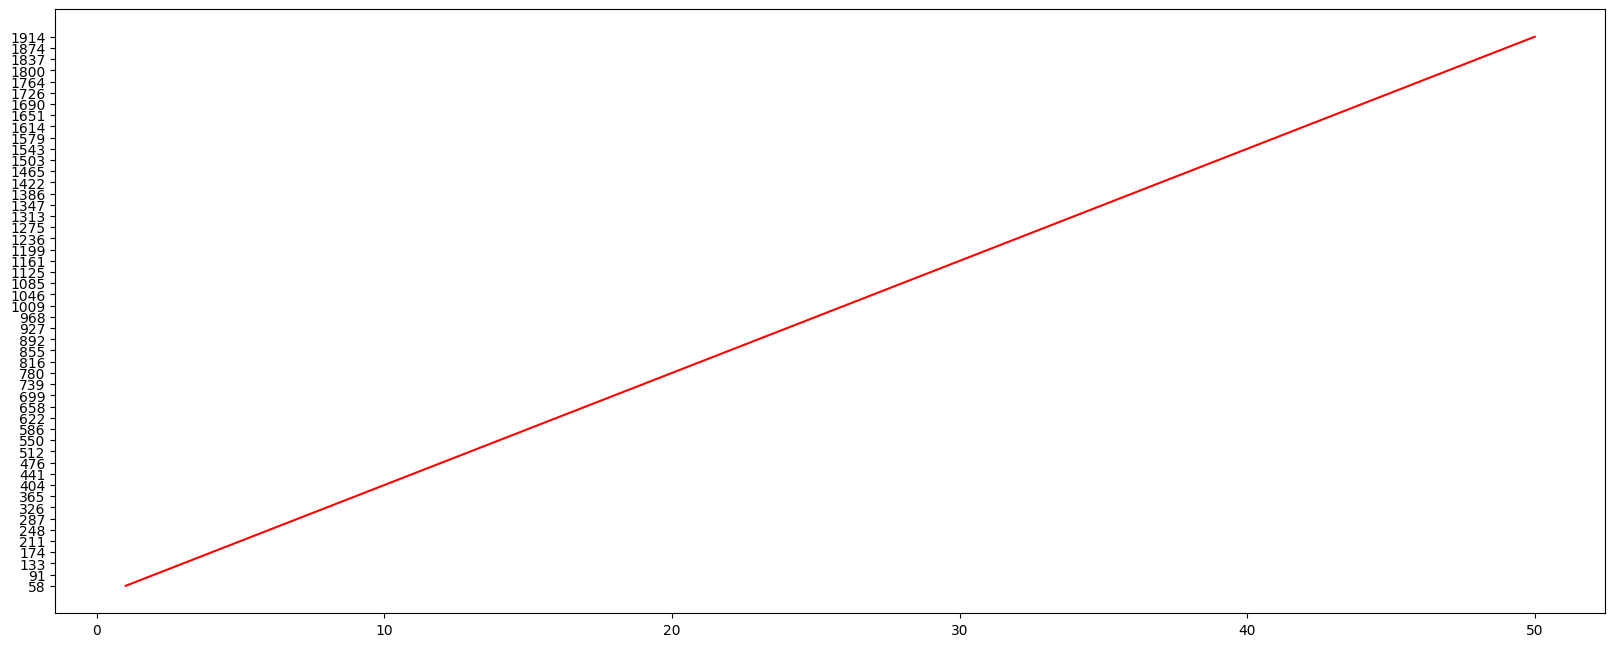

In [ ]:
fig=plt.figure(figsize=(20,8), dpi= 100, facecolor='w', edgecolor='k')
plt.plot(data['size_of_dict'][:50],data['file_size_array'][:50],color='r', label='line 1')
# plt.plot(data['size_of_dict'][:50],y_[:50], color='b',label='line 2')
plt.show()

In [ ]:
from sklearn.linear_model import LinearRegression
X = np.array(data['size_of_dict']).reshape(-1,1)
y = np.array(data['file_size_array']).astype('int')

reg = LinearRegression().fit(X, y)
print(f'Score {reg.score(X, y)}')
print(f'Coff: {reg.coef_} + intercept {reg.intercept_}')

Score 0.9999968754404466
Coff: [53.62849515] + intercept -895.7286103110382


In [ ]:
x_ = []
y_ = []
for i in data['size_of_dict']:
  x_.append(i)
  y_.append(i*53.6 -895.7)
y_[:100]


In [ ]:
number_of_text = 0
number_of_byte_in_bitarray = 0
for key in trie.bitarray_dict:
    number_of_text += len(key)
    number_of_byte_in_bitarray += 1 + len(trie.bitarray_dict[key])//8
print(f'Number of text {number_of_text} and number of bytes {number_of_byte_in_bitarray}')

Number of text 25479 and number of bytes 8691


**KL divergence between 2 texts:**

In [ ]:
trie_1 = Trie()

voc_count_1 = Counter(text_1)
voc_dl_1 = dict()   

for key in voc_count_1:
    voc_dl_1[key] = -math.log(voc_count_1[key]/len(text_1),2)

for key in voc_dl_1:
    trie_1.insert(key, voc_dl_1[key])

%prun min_seg_full_text_1, back_pointers_full_text_1, segmentation_list_full_text_1, sum_MDL_1, trie_code_length_1, vocab_dict_len_1, encoded_array_1, total_size_1 = find_MDL(text_1, trie_1, number_of_loop = 1, number_of_batches = 4)

In [ ]:
trie_2 = Trie()

voc_count_2 = Counter(text_2)
voc_dl_2 = dict()   

for key in voc_count_2:
    voc_dl_2[key] = -math.log(voc_count_2[key]/len(text_2),2)

for key in voc_dl_2:
    trie_2.insert(key, voc_dl_2[key])

%prun min_seg_full_text_2, back_pointers_full_text_2, segmentation_list_full_text_2, sum_MDL_2, trie_code_length_2, vocab_dict_len_2, encoded_array_2, total_size_2 = find_MDL(text_2, trie_2, number_of_loop = 1, number_of_batches = 4)

**KL divergence**

In [ ]:
def kl_div(p, q):
	  return np.sum(p*np.log2(p/q))
 
def KL_divergence(vocab_1, vocab_2):
    p_array = np.array
    set_vocab_1 = set(vocab_1.vocab_dict_address)
    set_vocab_2 = set(vocab_2.vocab_dict_address)

    print(len(set_vocab_1))
    print(len(set_vocab_2))
    union_set_vocabs = set_vocab_1.union(set_vocab_2)
    p_array = np.zeros((len(union_set_vocabs)))
    q_array = np.zeros((len(union_set_vocabs)))
    print(f'len of union {len(union_set_vocabs)}')
    print(f'overlap {len(set_vocab_1.intersection(set_vocab_2))}')

    for i, elem in enumerate(union_set_vocabs):
        try:
            p = (vocab_1.vocab_dict_address[elem].count_all_text + 0.5)/ (vocab_1.general_count + 1)
            if p == 0 :
                p = 0.5/ (vocab_1.general_count + 1)
        except:
            p = 0.5/ (vocab_1.general_count + 1)

        try:
            q = (vocab_2.vocab_dict_address[elem].count_all_text+0.5)/ (vocab_2.general_count + 1)
            if q == 0 :
                q = 0.5 / (vocab_2.general_count + 1)
        except:
            q = 0.5 / (vocab_2.general_count + 1)

        p_array[i] = p
        q_array[i] = q

    return kl_div(p_array, q_array), p_array, q_array
result, p_array, q_array = KL_divergence(trie_1, trie_2)

814
731
len of union 1035
overlap 510


In [ ]:
result

1.3394606620531482

In [ ]:
test_count = Counter(text_1)
test_count['q']

895

In [ ]:
def chunk_string(s, n):
    return [s[i:i+n] for i in range(len(s)-n+1)]

In [ ]:
test_count_2 = Counter(chunk_string(text, 2))

In [ ]:
test_count_2['qu']

895

In [ ]:
#Test example
trie_test_1 = Trie()
trie_test_1.insert('a', 3.5)
trie_test_1.vocab_dict_address['a'].count_all_text = 100
trie_test_1.insert('b', 3.2)
trie_test_1.vocab_dict_address['b'].count_all_text = 50
trie_test_1.insert('c', 3.1)
trie_test_1.vocab_dict_address['c'].count_all_text = 50
trie_test_1.general_count = 200

trie_test_2 = Trie()
trie_test_2.insert('a', 3.5)
trie_test_2.vocab_dict_address['a'].count_all_text = 100
trie_test_2.insert('b', 3.6)
trie_test_2.vocab_dict_address['b'].count_all_text = 100
trie_test_2.insert('c', 3.7)
trie_test_2.vocab_dict_address['c'].count_all_text = 100
trie_test_2.general_count = 300

In [ ]:
result, p_array, q_array = KL_divergence(trie_test_1, trie_test_2)
result

3
3
len of union 3
overlap {'b', 'a', 'c'}


0.08496250072115619

In [ ]:
result, p_array, q_array = KL_divergence(trie_test_2, trie_test_1)
result

3
3
len of union 3
overlap {'b', 'a', 'c'}


0.08170416594551039